In [1]:
import pandas as pd
import numpy as np

#Reading the train dataset
train = pd.read_csv("../DB\Input/train.csv")
test = pd.read_csv("../DB\Input/test.csv")
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

##### Quick EDA

In [19]:
#Quick EDA thanks to pandas_profiling

from pandas_profiling import ProfileReport

profile = ProfileReport(train, title="Pandas Profiling Report");
profile.to_file("../Visualization/Titanic_dataset.html");
profile.to_notebook_iframe()

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 76.91it/s]


##### Model setup

In [3]:
from pycaret.classification import *

#Pycaret is such a powerfool tool it doesn't need to know the data types, but I always will do it anyway.
setup = setup(data = train,
             target = 'Survived',
             fold = 5, # number of kfolds
             normalize = True, #transforms the numeric features by scaling them to a given range
             normalize_method = 'zscore', #Makes data more gaussian-like
             transformation_method = 'yeo-johnson', 
             numeric_imputation = 'median', #imputes missing values with the median of the column
             create_clusters=True, #Creates clusters as feature
             cluster_iter=5,
             numeric_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'],
             categorical_features =["Sex", "Embarked"],
             high_cardinality_features=["Ticket", "Cabin"],
             ignore_features = ["PassengerId", "Name"],
             data_split_stratify=True, #makes a split so that the proportion of values in the sample produced will be the same as the proportion,
             log_experiment = True, #log this in Mlflow for Mlops
             experiment_name = "Titanic Prediction", #for MLops to be able to identify the experiment
             session_id = 123,
             silent = True,
             verbose = False)

In [31]:
# This will compare the models and return the best model
compare_models()

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [4]:
#creating the lightgbm model because of its high accuracy, speed and ability to be interpreted
model = create_model("lightgbm")

In [20]:
#Print model hyperparameters
print(model)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


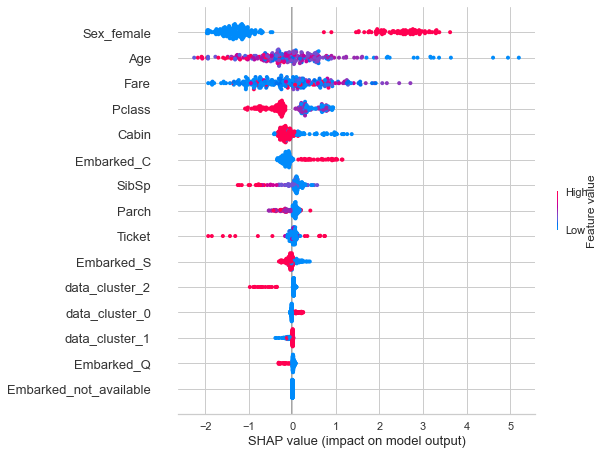

In [6]:
#interpreting model with shap values
interpret_model(model)

### Some Shap insights ### 

* Being female has a higher positive impact on the model output than being male.
* Being young has a hightimpact on the model output.
* Data clusters don't have a high impact on the model output.
* First classes have a high positive impact on the model output.
* First Cabin numbers have a high positive impact in the model output.

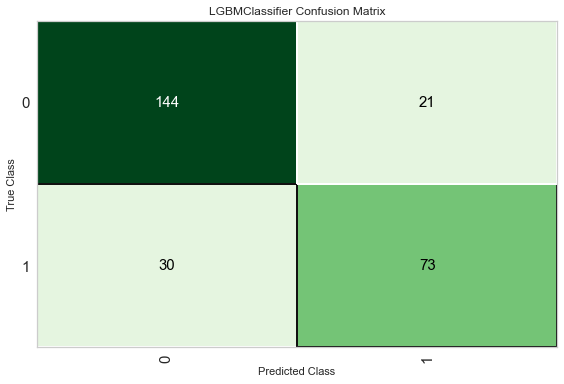

In [12]:
plot_model(model, plot="confusion_matrix")

In [15]:
#This trains the model with the whole dataset for deployment.
model = finalize_model(model)

#Saving the model for later deployment.
save_model(model, "../Models/Titanic_model");

Transformation Pipeline and Model Successfully Saved


##### Predicting 

In [18]:
#Loading the model .pkl
loaded_model = load_model("../Models/Titanic_model")

#Predicting the test dataset
predictions = predict_model(loaded_model, test)

#Saving predictions dataset
predictions.to_csv("../DB/Output_pred/predictions.csv")

#Head of the test dataset
predictions.head()

Transformation Pipeline and Model Successfully Loaded


PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  Label   Score  
0  34.5      0      0   330911   7.8292   NaN        Q      0  0.9535  
1  47.0      1      0   363272   7.0000   NaN        S      0  0.8725  
2  62.0      0      0   240276   9.6875   NaN        Q      0  0.8655  
3  27.0      0      0   315154   8.6625   NaN        S      0  0.6683  
4  22.0      1      1  3101298  12.2875   NaN        S      0  0.8308